<a href="https://colab.research.google.com/github/egaraev/robocar/blob/main/Object_detect_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tflite-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [5]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

dataset_is_split = False #@param ["False", "True"] {type:"raw"}

In [6]:
if use_custom_dataset:

  # The ZIP file you uploaded:
  !unzip dataset.zip

  # Your labels map as a dictionary (zero is reserved):
  label_map = {1: 'green light', 2: 'limit 30', 3: 'limit 50', 4: 'pedestrian sign', 5: 'person', 6: 'red light', 7: 'round', 8: 'second person', 9: 'stop', 10: 'traffic light sign'} 

  if dataset_is_split:
    # If your dataset is already split, specify each path:
    train_images_dir = 'dataset/train/images'
    train_annotations_dir = 'dataset/train/annotations'
    val_images_dir = 'dataset/validation/images'
    val_annotations_dir = 'dataset/validation/annotations'
    test_images_dir = 'dataset/test/images'
    test_annotations_dir = 'dataset/test/annotations'
  else:
    # If it's NOT split yet, specify the path to all images and annotations
    images_in = 'dataset/images'
    annotations_in = 'dataset/images'

Archive:  dataset.zip
   creating: dataset/images/
  inflating: dataset/images/20230407_180957.jpg  
  inflating: dataset/images/20230407_180957.xml  
  inflating: dataset/images/20230407_181019.jpg  
  inflating: dataset/images/20230407_181019.xml  
  inflating: dataset/images/20230407_181100.jpg  
  inflating: dataset/images/20230407_181100.xml  
  inflating: dataset/images/20230407_181149.jpg  
  inflating: dataset/images/20230407_181149.xml  
  inflating: dataset/images/20230407_181240.jpg  
  inflating: dataset/images/20230407_181240.xml  
  inflating: dataset/images/20230407_181343.jpg  
  inflating: dataset/images/20230407_181343.xml  
  inflating: dataset/images/20230407_181450.jpg  
  inflating: dataset/images/20230407_181450.xml  
  inflating: dataset/images/20230407_181532.jpg  
  inflating: dataset/images/20230407_181532.xml  
  inflating: dataset/images/20230407_181614.jpg  
  inflating: dataset/images/20230407_181614.xml  
  inflating: dataset/images/20230407_181702.jpg  

In [7]:
def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  dir_content = list(os.walk(images_path))
  if not dir_content:
      raise ValueError(f"No directories found in {images_path}")
  _, dirs, _ = dir_content[0]


  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [8]:
import random, shutil

# We need to instantiate a separate DataLoader for each split dataset
if use_custom_dataset:
  if dataset_is_split:
    train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)
  else:
    train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                                 val_split=0.2, test_split=0.2,
                                                 out_path='split-dataset')
    train_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(train_dir, 'images'),
        os.path.join(train_dir, 'annotations'), label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(val_dir, 'images'),
        os.path.join(val_dir, 'annotations'), label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(test_dir, 'images'),
        os.path.join(test_dir, 'annotations'), label_map=label_map)
    
  print(f'train count: {len(train_data)}')
  print(f'validation count: {len(validation_data)}')
  print(f'test count: {len(test_data)}')

train count: 60
validation count: 20
test count: 20


In [9]:
spec = object_detector.EfficientDetLite0Spec()

In [10]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=500, 
                               batch_size=10, 
                               train_whole_model=True)

Epoch 1/500
6/6 [==============================] - 90s 8s/step - det_loss: 1.8440 - cls_loss: 1.1576 - box_loss: 0.0137 - reg_l2_loss: 0.0644 - loss: 1.9084 - learning_rate: 0.0101 - gradient_norm: 0.9002 - val_det_loss: 1.6987 - val_cls_loss: 1.1460 - val_box_loss: 0.0111 - val_reg_l2_loss: 0.0644 - val_loss: 1.7631
Epoch 2/500
6/6 [==============================] - 44s 8s/step - det_loss: 1.7840 - cls_loss: 1.1479 - box_loss: 0.0127 - reg_l2_loss: 0.0644 - loss: 1.8484 - learning_rate: 0.0125 - gradient_norm: 0.7963 - val_det_loss: 1.6363 - val_cls_loss: 1.1311 - val_box_loss: 0.0101 - val_reg_l2_loss: 0.0644 - val_loss: 1.7008
Epoch 3/500
6/6 [==============================] - 53s 9s/step - det_loss: 1.6575 - cls_loss: 1.1283 - box_loss: 0.0106 - reg_l2_loss: 0.0644 - loss: 1.7219 - learning_rate: 0.0125 - gradient_norm: 0.8018 - val_det_loss: 1.5407 - val_cls_loss: 1.1056 - val_box_loss: 0.0087 - val_reg_l2_loss: 0.0644 - val_loss: 1.6051
Epoch 4/500
6/6 [==========================

In [11]:
model.evaluate(test_data)

1/1 [==============================] - 14s 14s/step



{'AP': 0.71992654,
 'AP50': 0.92484564,
 'AP75': 0.85834867,
 'APs': 0.25,
 'APm': 0.72509396,
 'APl': -1.0,
 'ARmax1': 0.7517368,
 'ARmax10': 0.78915787,
 'ARmax100': 0.79165787,
 'ARs': 0.25,
 'ARm': 0.7972924,
 'ARl': -1.0,
 'AP_/green light': 0.76642287,
 'AP_/limit 30': 0.5805717,
 'AP_/limit 50': 0.5763278,
 'AP_/pedestrian sign': 0.75087243,
 'AP_/person': 0.769166,
 'AP_/red light': 0.76758534,
 'AP_/round': 0.70488423,
 'AP_/second person': 0.7926699,
 'AP_/stop': 0.8127007,
 'AP_/traffic light sign': 0.6780647}

In [12]:
TFLITE_FILENAME = 'efficientdet-lite.tflite'
LABELS_FILENAME = 'labels.txt'

In [13]:
model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

In [14]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

20/20 [==============================] - 69s 3s/step



{'AP': 0.6925537,
 'AP50': 0.90595734,
 'AP75': 0.83800703,
 'APs': 0.05,
 'APm': 0.699461,
 'APl': -1.0,
 'ARmax1': 0.72642106,
 'ARmax10': 0.7421316,
 'ARmax100': 0.7421316,
 'ARs': 0.05,
 'ARm': 0.7492778,
 'ARl': -1.0,
 'AP_/green light': 0.7152829,
 'AP_/limit 30': 0.56667644,
 'AP_/limit 50': 0.5090543,
 'AP_/pedestrian sign': 0.74895465,
 'AP_/person': 0.75268674,
 'AP_/red light': 0.7549165,
 'AP_/round': 0.6889771,
 'AP_/second person': 0.76364666,
 'AP_/stop': 0.78677046,
 'AP_/traffic light sign': 0.63857144}

In [15]:
import random

# If you're using a custom dataset, we take a random image from the test set:
if use_custom_dataset:
  images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
  filenames = os.listdir(os.path.join(images_path))
  random_index = random.randint(0,len(filenames)-1)
  INPUT_IMAGE = os.path.join(images_path, filenames[random_index])

In [16]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.8/393.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.1 MB/s eta 0:00:00


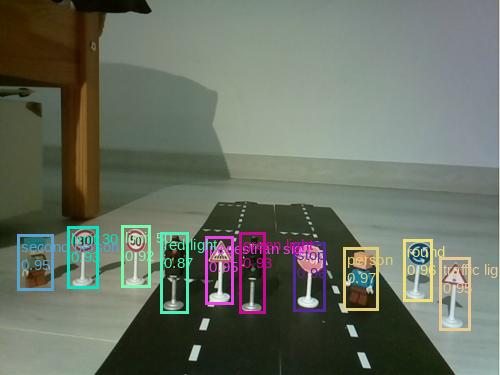

In [17]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.2, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

In [18]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  34571      0 --:--:-- --:--:-- --:--:-- 34571
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [975 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/

In [19]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler $TFLITE_FILENAME -d --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Searching for valid delegate with step 1
Try to compile segment with 267 ops
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed: Compilation failed due to large activation tensors in model.
Compilation child process completed within timeout period.
Compilation failed! 
Try to compile segment with 266 ops
Intermediate tensors: tfl.dequantize,Sigmoid1
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed: Compilation failed due to large activation tensors in model.
Compilation child process completed within timeout period.
Compilation failed! 
Try to compile segment with 265 ops
Intermediate tensors: Sigmoid1,concat_1
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed

In [20]:
from google.colab import drive
drive.mount('/content/drive')
model_dir = '/content/drive/MyDrive/Retraining/'

Mounted at /content/drive
total 12
drwx------ 2 root root 4096 Apr  7 21:04 'Colab Notebooks'
drwx------ 2 root root 4096 Apr 10 16:58 'My drive content'
drwx------ 2 root root 4096 Apr 11 18:13  Retraining


In [22]:
!cp efficientdet-lite.tflite labels.txt efficientdet-lite_edgetpu.tflite  '{model_dir}/'
!ls -ltra '{model_dir}'/..

total 12
drwx------ 2 root root 4096 Apr  7 21:04 'Colab Notebooks'
drwx------ 2 root root 4096 Apr 10 16:58 'My drive content'
drwx------ 2 root root 4096 Apr 14 19:00  Retraining
